In [1]:
import os
import numpy as np
import pandas as pd
import joblib
import json
import tensorflow as tf
import gc
import matplotlib.pyplot as plt
import sys
from tqdm.notebook import tqdm

In [2]:
# Ringer V8
tuning_path = '/home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/tunings/TrigL2_20180125_v8'
# Ringer V8.1/2
#tuning_path = '/home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/tunings/TrigL2_20210907_v8-1'
tuning_file = "ElectronRingerMediumTriggerConfig.json"
with open(os.path.join(tuning_path,tuning_file)) as f:
    conf = json.load(f)

In [3]:
#conf

In [4]:
def open_boosted(path= ""):
    '''
    This function will get a .npz file and transform into a pandas DataFrame. 
    The .npz has three types of data: float, int and bool this function will concatenate these features and reorder them.

    Arguments:
    path (str) - the full path to .npz file
    '''
    # open the file
    d = dict(np.load(path, allow_pickle=True))   
    #print(d.keys()) 
    # create a list of temporary dataframes that should be concateneted into a final one
    df_list = []
    for itype in ['float', 'int', 'bool', 'object']:
        df_list.append(pd.DataFrame(data=d['data_%s' %itype], columns=d['features_%s' %itype]))
    # concat the list
    df = pd.concat(df_list, axis=1)
    # return the DataFrame with ordered features.
    df = df[d['ordered_features']]
    # add the target information
    df['target'] = d['target']
    df['et_bin'] = d['etBinIdx']
    df['eta_bin'] = d['etaBinIdx']
    # remove the list of DataFrame and collect into garbage collector
    del df_list, d
    gc.collect()
    return df

In [5]:
# my pc path
#data_path = '/home/pedro/Desktop/IC/data/mc16_13TeV.302236_309995_341330.sgn.boosted_probes.WZ_llqq_plus_radion_ZZ_llqq_plus_ggH3000.merge.25bins/mc16_13TeV.302236_309995_341330.sgn.boosted_probes.WZ_llqq_plus_radion_ZZ_llqq_plus_ggH3000.merge.25bins_et4_eta0.npz'
# LPS path
data_path = '/home/pedro.lima/data/mc16_13TeV.302236_309995_341330.sgn.boosted_probes.WZ_llqq_plus_radion_ZZ_llqq_plus_ggH3000.merge.25bins.v2/mc16_13TeV.302236_309995_341330.sgn.boosted_probes.WZ_llqq_plus_radion_ZZ_llqq_plus_ggH3000.merge.25bins.v2_et4_eta0.npz'
df = open_boosted(data_path)

In [6]:
df.head()
df.columns.values

array(['RunNumber', 'avgmu', 'trig_L2_cl_et', 'trig_L2_cl_eta',
       'trig_L2_cl_phi', 'trig_L2_cl_reta', 'trig_L2_cl_ehad1',
       'trig_L2_cl_eratio', 'trig_L2_cl_f1', 'trig_L2_cl_f3',
       'trig_L2_cl_weta2', 'trig_L2_cl_wstot', 'trig_L2_cl_e2tsts1',
       'trig_L2_cl_ring_0', 'trig_L2_cl_ring_1', 'trig_L2_cl_ring_2',
       'trig_L2_cl_ring_3', 'trig_L2_cl_ring_4', 'trig_L2_cl_ring_5',
       'trig_L2_cl_ring_6', 'trig_L2_cl_ring_7', 'trig_L2_cl_ring_8',
       'trig_L2_cl_ring_9', 'trig_L2_cl_ring_10', 'trig_L2_cl_ring_11',
       'trig_L2_cl_ring_12', 'trig_L2_cl_ring_13', 'trig_L2_cl_ring_14',
       'trig_L2_cl_ring_15', 'trig_L2_cl_ring_16', 'trig_L2_cl_ring_17',
       'trig_L2_cl_ring_18', 'trig_L2_cl_ring_19', 'trig_L2_cl_ring_20',
       'trig_L2_cl_ring_21', 'trig_L2_cl_ring_22', 'trig_L2_cl_ring_23',
       'trig_L2_cl_ring_24', 'trig_L2_cl_ring_25', 'trig_L2_cl_ring_26',
       'trig_L2_cl_ring_27', 'trig_L2_cl_ring_28', 'trig_L2_cl_ring_29',
       'trig_L2_cl_ri

In [7]:
def add_tuning_decision(df, tuning_path, config_dict):
        #find et and eta bin
        idx = (df['et_bin']+df['eta_bin']).unique()[0]
        #print(idx)

        m_path = tuning_path
        m_model_path = os.path.join(m_path,config_dict["Model__path"][idx].replace('.onnx',''))
        with open(m_model_path + '.json', 'r') as f:
                sequential = json.load(f) 
        model = tf.keras.models.model_from_json(json.dumps(sequential, separators=(',', ':')))
        model.load_weights(m_model_path + '.h5')
        slope, offset = config_dict["Threshold__slope"][idx],config_dict["Threshold__offset"][idx]

        # ring list
        rings = ['trig_L2_cl_ring_%i' %(iring) for iring in range(100)]
        #                                                          |
        #                                                   alterado no v8.1/2

        def norm1( data ): 
                norms = np.abs( data.sum(axis=1) )
                norms[norms==0] = 1
                return data/norms[:,None] 
        df['nn_output_%s_%s'%(config_dict['__operation__'].lower(),config_dict['__version__'])] = model.predict(norm1(df[rings].values)) 
        df['thr_%s_%s' %(config_dict['__operation__'].lower(),config_dict['__version__'])] = df['avgmu']*slope + offset
        df['nn_decision_%s_%s' %(config_dict['__operation__'].lower(),config_dict['__version__'])] = 0
        df.loc[df['nn_output_%s_%s' %(config_dict['__operation__'].lower(),config_dict['__version__'])] > df['thr_%s_%s' %(config_dict['__operation__'].lower(),config_dict['__version__'])],'nn_decision_%s_%s' %(config_dict['__operation__'].lower(),config_dict['__version__'])] = 1 

def add_tuning_decision_removing_a_ring(df, tuning_path, config_dict, ring_id=None):
        
        if ring_id<0 or ring_id>99:
                return -1

        #find et and eta bin
        idx = (df['et_bin']+df['eta_bin']).unique()[0]
        #print(idx)

        m_path = tuning_path
        m_model_path = os.path.join(m_path,config_dict["Model__path"][idx].replace('.onnx',''))
        with open(m_model_path + '.json', 'r') as f:
                sequential = json.load(f) 
        model = tf.keras.models.model_from_json(json.dumps(sequential, separators=(',', ':')))
        model.load_weights(m_model_path + '.h5')
        slope, offset = config_dict["Threshold__slope"][idx],config_dict["Threshold__offset"][idx]

        # ring list
        rings = ['trig_L2_cl_ring_%i' %(iring) for iring in range(100)]
        #                                                          |
        #                                                alterado no v8.1/2

        # replace a ring value by its mean
        df['trig_L2_cl_ring_%i' %(ring_id)] = df['trig_L2_cl_ring_%i' %(ring_id)].mean()

        def norm1( data ): 
                norms = np.abs( data.sum(axis=1) )
                norms[norms==0] = 1
                return data/norms[:,None] 
        df['nn_output_%s_%s_removing_%i'%(config_dict['__operation__'].lower(),config_dict['__version__'], ring_id)] = model.predict(norm1(df[rings].values)) 
        df['thr_%s_%s' %(config_dict['__operation__'].lower(),config_dict['__version__'])] = df['avgmu']*slope + offset
        df['nn_decision_%s_%s_removing_%i' %(config_dict['__operation__'].lower(),config_dict['__version__'], ring_id)] = 0
        df.loc[df['nn_output_%s_%s_removing_%i' %(config_dict['__operation__'].lower(),config_dict['__version__'], ring_id)] > df['thr_%s_%s' %(config_dict['__operation__'].lower(),config_dict['__version__'])],'nn_decision_%s_%s_removing_%i' %(config_dict['__operation__'].lower(),config_dict['__version__'], ring_id)] = 1 


In [8]:
add_tuning_decision(df=df, tuning_path=tuning_path, config_dict=conf)

In [9]:
df.head()

,RunNumber,avgmu,trig_L2_cl_et,trig_L2_cl_eta,trig_L2_cl_phi,trig_L2_cl_reta,trig_L2_cl_ehad1,trig_L2_cl_eratio,trig_L2_cl_f1,trig_L2_cl_f3,...,trig_L2_el_cut_pt0to15,trig_L2_el_cut_pt15to20,trig_L2_el_cut_pt20to50,trig_L2_el_cut_pt50toInf,target,et_bin,eta_bin,nn_output_medium_v8,thr_medium_v8,nn_decision_medium_v8
0,310000,28.49,2.384941e+05,-0.607868,-2.707992,0.972986,144.720963,0.979702,0.108998,0.009339,...,True,True,True,True,1.0,4,0,-4.603082,-0.088699,0
1,310000,46.50,9.523698e+05,-0.316026,1.304594,0.973886,4731.140625,0.993113,0.101171,0.013992,...,True,True,True,True,1.0,4,0,0.464552,-0.337748,1
2,310000,60.50,1.361326e+06,0.747472,-0.162229,0.965323,3911.929199,1.011388,0.238911,0.004983,...,True,True,True,True,1.0,4,0,-0.536153,-0.531344,0
3,310000,43.50,6.687857e+05,0.108909,-2.976708,0.970706,2144.790527,0.995141,0.166586,0.010647,...,True,True,True,True,1.0,4,0,-0.595760,-0.296262,0
4,310000,38.50,1.286490e+06,-0.224995,-2.689110,0.970724,7945.402344,0.994471,0.064834,0.018838,...,True,True,True,True,1.0,4,0,1.692493,-0.227121,1


In [10]:
df.columns.values

array(['RunNumber', 'avgmu', 'trig_L2_cl_et', 'trig_L2_cl_eta',
       'trig_L2_cl_phi', 'trig_L2_cl_reta', 'trig_L2_cl_ehad1',
       'trig_L2_cl_eratio', 'trig_L2_cl_f1', 'trig_L2_cl_f3',
       'trig_L2_cl_weta2', 'trig_L2_cl_wstot', 'trig_L2_cl_e2tsts1',
       'trig_L2_cl_ring_0', 'trig_L2_cl_ring_1', 'trig_L2_cl_ring_2',
       'trig_L2_cl_ring_3', 'trig_L2_cl_ring_4', 'trig_L2_cl_ring_5',
       'trig_L2_cl_ring_6', 'trig_L2_cl_ring_7', 'trig_L2_cl_ring_8',
       'trig_L2_cl_ring_9', 'trig_L2_cl_ring_10', 'trig_L2_cl_ring_11',
       'trig_L2_cl_ring_12', 'trig_L2_cl_ring_13', 'trig_L2_cl_ring_14',
       'trig_L2_cl_ring_15', 'trig_L2_cl_ring_16', 'trig_L2_cl_ring_17',
       'trig_L2_cl_ring_18', 'trig_L2_cl_ring_19', 'trig_L2_cl_ring_20',
       'trig_L2_cl_ring_21', 'trig_L2_cl_ring_22', 'trig_L2_cl_ring_23',
       'trig_L2_cl_ring_24', 'trig_L2_cl_ring_25', 'trig_L2_cl_ring_26',
       'trig_L2_cl_ring_27', 'trig_L2_cl_ring_28', 'trig_L2_cl_ring_29',
       'trig_L2_cl_ri

In [11]:
#def replace_column(df, column):
#    '''Replaces a column (in this case a ring) with its average value'''
#    df[column] = np.mean(df[column])
#    return df

# target_col = df['target']
#el_lh_col = df.loc[:,'el_lh%s'%(conf['__operation__'].lower())]

#total_ee = total_jets = 0
#for row in range(len(df.index)):
#    if el_lh_col[row]==1:
#        total_ee += 1
#    else:
#        total_jets += 1

#def eff (df, decisions, total, threshold=None):
#    passed_ee = passed_jets = 0
#    nn_decision_col = df.loc[:,'nn_decision_%s_v8'%(conf['__operation__'].lower())]
#    nn_output_col = df.loc[:,'nn_output_%s_v8'%(conf['__operation__'].lower())]
#    decision_jet = []
#    decision_ee = []
#
#    for irow in range(len(nn_output_col)):
#        if nn_decision_col[irow] == 1:
#            decision_ee += [nn_output_col[irow]]
#        else:
#            decision_jet += [nn_output_col[irow]]
#    
#    plt.hist(decision_jet, bins=100, color='red', alpha=0.5, label='Jets')
#    plt.hist(decision_ee, bins=100, color='blue', alpha=0.5, label='Electrons')
#    plt.legend()
#    plt.show()

nn_decision_col = df.loc[:,'nn_decision_%s_%s' %(conf['__operation__'].lower(),conf['__version__'])]
nn_output_col = df.loc[:,'nn_output_%s_%s' %(conf['__operation__'].lower(),conf['__version__'])]
#el_lh_col = df.loc[:,'el_lh%s'%(conf['__operation__'].lower())]
decision_jet = []
decision_ee = []

for irow in range(len(nn_output_col)):
    if nn_decision_col[irow] == 1:
        decision_ee += [nn_output_col[irow]]
    else:
        decision_jet += [nn_output_col[irow]]

def calculate_eff(values, threshold, first):
    passed=0
    total = len(values)
    if first:
        for value in values:
            if value<threshold:
                passed+=1
    else:
        for value in values:
            if value>threshold:
                passed+=1
    return passed/total

def geo_mean(iterable):
    a = np.array(iterable)
    return a.prod()**(1.0/len(a))

def calculate_sp(decision_jet, decision_ee, threshold):
    eff_jet = calculate_eff(decision_jet, threshold, True)
    eff_ee = calculate_eff(decision_ee, threshold, False)
    effs = [eff_jet, eff_ee]
    arit_mean = np.mean(effs)
    geom_mean = geo_mean(effs)
    return np.sqrt(arit_mean*geom_mean)

def update_progress(progress):
    barLength = 100 # Modify this to change the length of the progress bar
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    #text = "\rPercent: [{0}] {1}% {2}".format( "#"*block + "-"*(barLength-block), progress*100, status)
    text = "\rPercent: [%s] %.2f%% %s"%( "#"*block + "-"*(barLength-block), progress*100, status)
    sys.stdout.write(text)
    sys.stdout.flush()

sp_vector = []
possible_thresholds = np.linspace(-1,1,100)
progresso=0

for est_threshold in tqdm(list(possible_thresholds)):
    sp_vector += [calculate_sp(decision_jet, decision_ee, est_threshold)]
    #progresso += 0.01
    #update_progress(progresso)

    
#parameter = eff(df, total_ee)
#print (total_ee, total_jets)
threshold = possible_thresholds[np.argmax(sp_vector)]
parameter = sp_vector[np.argmax(sp_vector)]
parameter

  0%|          | 0/100 [00:00<?, ?it/s]

0.9533150268971269

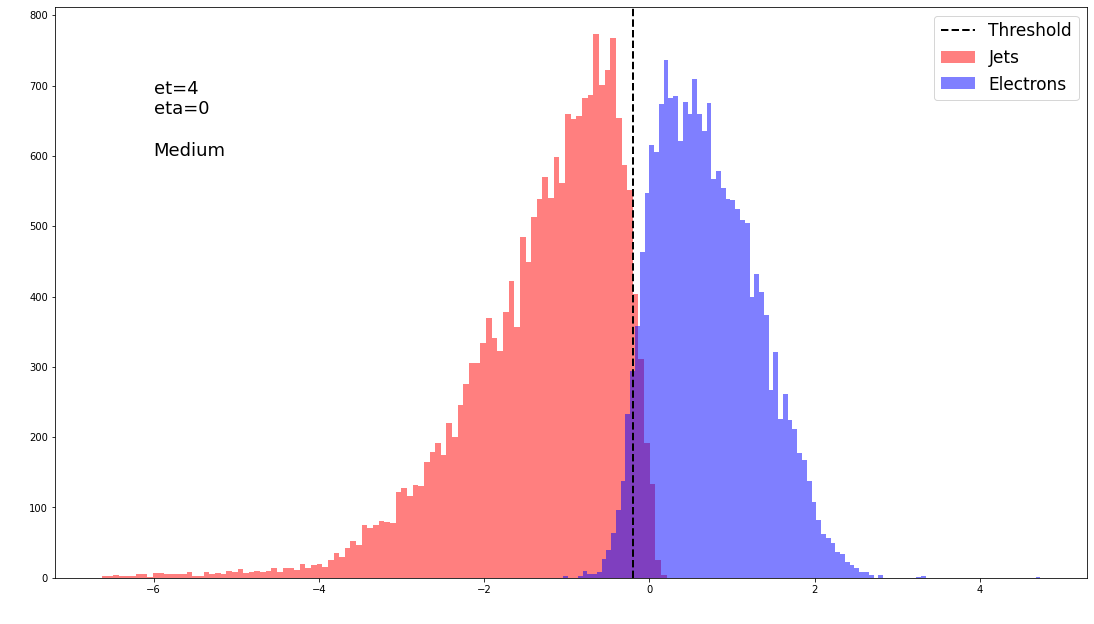

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.hist(decision_jet, bins=100, color='red', alpha=0.5, label='Jets')
plt.hist(decision_ee, bins=100, color='blue', alpha=0.5, label='Electrons')
plt.axvline(x=possible_thresholds[np.argmax(sp_vector)], color='black', ls='--', lw=2, label='Threshold')
plt.xlabel('Neural Network output', color='white', size=18)
plt.ylabel('Number of events', color='white', size=18)
plt.legend(prop={'size': 17})
plt.text(-6, 600, 'et=4\neta=0\n\n%s'%(conf['__operation__']), size=18)

plt.show()

In [13]:
data = df.copy(deep=True)
progresso = 0
best_sps=[]
delta_sps = []

for iring in tqdm(range(100)):
    #               |
    # alterado no v8.1/2
    #sp_vector = []
    add_tuning_decision_removing_a_ring(df=data, tuning_path=tuning_path, config_dict=conf, ring_id=iring)
    data['trig_L2_cl_ring_%i' %(iring)]=df['trig_L2_cl_ring_%i' %(iring)]

    nn_decision_col = data.loc[:,'nn_decision_%s_%s_removing_%i'%(conf['__operation__'].lower(),conf['__version__'], iring)]
    nn_output_col = data.loc[:,'nn_output_%s_%s_removing_%i'%(conf['__operation__'].lower(),conf['__version__'], iring)]
    #el_lh_col = df.loc[:,'el_lh%s'%(conf['__operation__'].lower())]
    decision_jet = []
    decision_ee = []

    for irow in tqdm(range(len(nn_output_col)), leave=False):
        if nn_decision_col[irow] == 1:
            decision_ee += [nn_output_col[irow]]
        else:
            decision_jet += [nn_output_col[irow]]

    #possible_thresholds = np.linspace(-1,1,100)
    #for est_threshold in list(possible_thresholds):
    #    sp_local = calculate_sp(decision_jet, decision_ee, est_threshold)
    #    sp_vector += [sp_local]
    #    progresso += 1/100/100
    #    update_progress(progresso)
    #best_sps += [sp_vector[np.argmax(sp_vector)]]
    #delta_sps+=[parameter-sp_vector[np.argmax(sp_vector)]]

    sp_local = calculate_sp(decision_jet, decision_ee, threshold)
    best_sps += [sp_local]
    delta_sps += [parameter-sp_local]
    #progresso += 1/100
    #update_progress(progresso)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

  0%|          | 0/39199 [00:00<?, ?it/s]

In [14]:
norm_sps = []
abs_delta_sps=[]
for iring in range(len(delta_sps)):
    abs_delta_sps += [np.abs(delta_sps[iring])]

max_abs_sp = abs_delta_sps[np.argmax(abs_delta_sps)]
max_sp = delta_sps[np.argmax(abs_delta_sps)]

for iring in range(len(delta_sps)):
    norm_sps += [delta_sps[iring]/max_abs_sp*100]

norm_sps


[-0.540504158569604,
 0.8255632231660737,
 0.2934325830896235,
 0.8255632231660737,
 -0.5396487645199858,
 0.8179530254069444,
 1.6692645162865043,
 0.5558798668839688,
 -30.33920924517864,
 -27.27741134244631,
 11.680096792883244,
 -100.0,
 0.0157397338590409,
 8.58268289053079,
 -8.13246070644486,
 3.1184612461988825,
 1.3466013588116932,
 2.208485742133394,
 4.913610963350521,
 -1.1360972702255618,
 3.824783094320598,
 4.295098281520745,
 5.500555592755166,
 2.982081494092832,
 -2.6162118815454485,
 -0.41250384821107744,
 -0.31440443606330976,
 -0.35000759645116747,
 -0.16868431433844103,
 0.17922527039924116,
 2.1711151275121408,
 -0.26763175932430167,
 -2.706775417151518,
 3.993156925585016,
 0.6870503068530092,
 0.7904464468846893,
 1.5705879606792479,
 4.054418902488768,
 -1.3686966360597033,
 1.102026511942145,
 -0.25022340890533096,
 0.9068979682325534,
 -1.4119777878939497,
 11.952697064016895,
 2.7296816579548544,
 0.9712577868887016,
 4.701207090010495,
 1.7362022336703051,

In [26]:
sps = {'best':best_sps, 'delta':delta_sps, 'norm':norm_sps}

with open("sp_lists_boosted.json", "w") as fp:
    json.dump(sps,fp)
    
with open("sp_lists_boosted.json", "r") as fp:
    sps = json.load(fp)

In [15]:
delta_sps

[-5.101630424486636e-05,
 7.792203611878268e-05,
 2.7696079108574523e-05,
 7.792203611878268e-05,
 -5.093556658097853e-05,
 7.720373606856512e-05,
 0.00015755606146194978,
 5.246756377896844e-05,
 -0.0028636122495279137,
 -0.002574619813733414,
 0.0011024436392351733,
 -0.009438651569282364,
 1.4856186368872315e-06,
 0.0008100895333336133,
 -0.0007675946300901293,
 0.0002943406913518132,
 0.0001271010102854575,
 0.00020845127415725084,
 0.0004637786183007142,
 -0.0001072322628247191,
 0.0003610079495537377,
 0.00040539936135097765,
 0.0005191782767748343,
 0.000281468281739472,
 -0.0002469351238132411,
 -3.8934800942524994e-05,
 -2.9675539238382953e-05,
 -3.30359974950456e-05,
 -1.592152468243846e-05,
 1.6916448797088535e-05,
 0.00020492399205385148,
 -2.5260829251361194e-05,
 -0.000255483100387921,
 0.0003769001688206375,
 6.484828456954084e-05,
 7.460748596321842e-05,
 0.0001482423251976117,
 0.0003826824733650369,
 -0.0001291865065181641,
 0.00010401644266333498,
 -2.361771571135484

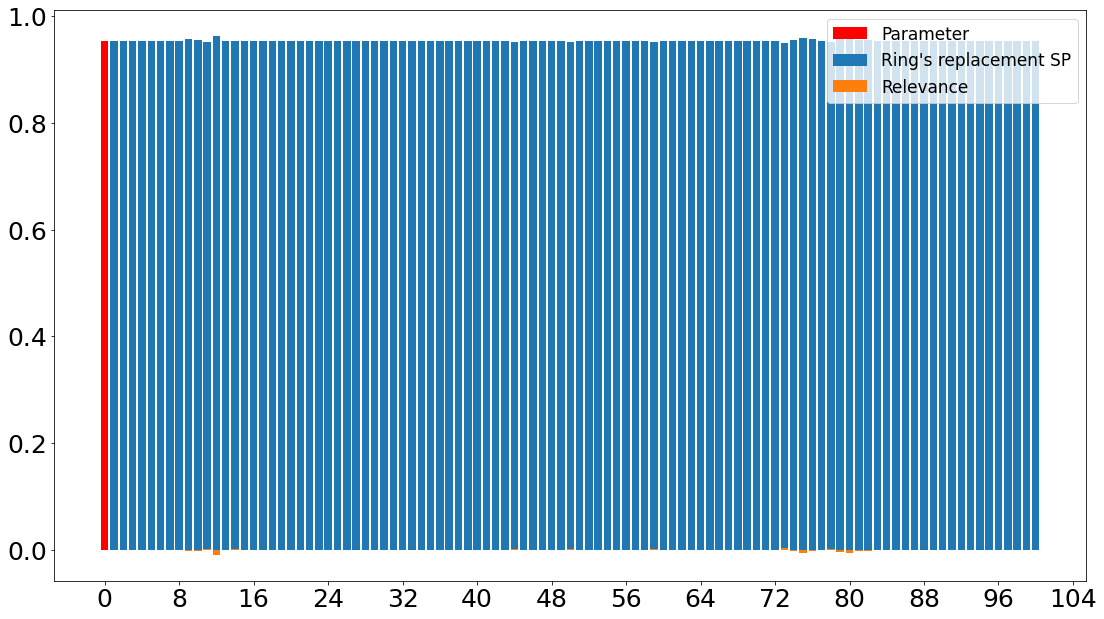

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.rc('font', size=8)
plt.rc('xtick', labelsize=25, color='black')
plt.rc('ytick', labelsize=25, color='black')
ax.bar(0, parameter, color='red', label='Parameter')
ax.bar(range(1,101), best_sps, label='Ring\'s replacement SP')
#               |
#        alterado no v8.1/2
#               |
ax.bar(range(1,101), delta_sps, label='Relevance')
ax.xaxis.set_major_locator(plt.MultipleLocator(8))
ax.legend(loc=1, prop={'size': 17})

plt.savefig('Relevance_full_boosted_data17_lhmedium_et4_eta0.png')
plt.savefig('Relevance_full_boosted_data17_lhmedium_et4_eta0.pdf')

plt.show()

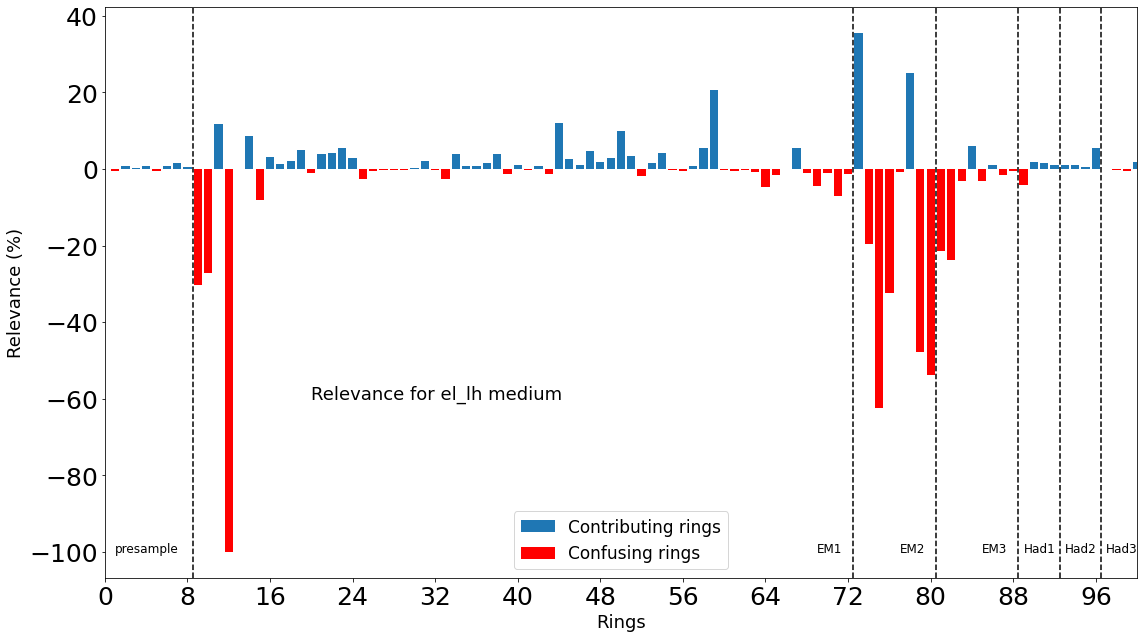

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
bars = plt.bar(range(1,101), norm_sps, label='Contributing rings')
#                       |
#               alterado no v8.1/2
plt.bar(1,0, label='Confusing rings', color='red')
plt.legend(prop={'size': 17})
ax.xaxis.set_major_locator(plt.MultipleLocator(8))
for bar in range(100):
#                 |
#        alterado no v8.1/2
    if delta_sps[bar]<0:
        bars[bar].set_fc('red')

xcoords = [8+.5,8+64+.5, 8+64+8+.5, 8+64+8+8+.5, 8+64+8+8+4+.5, 8+64+8+8+4+4+.5, 100+.5]
colors = ['black' for i in range(len(xcoords))]

for xc,c in zip(xcoords, colors):
    plt.axvline(x=xc, c=c, ls='--')

if max_sp > 0:
    where = 100
else:
    where = -100

fig.patch.set_facecolor('white')
plt.text(1,  where, 'presample', size=12)
plt.text(69, where, 'EM1', size=12)
plt.text(77, where, 'EM2', size=12)
plt.text(85, where, 'EM3', size=12)
plt.text(89, where, 'Had1', size=12)
plt.text(93, where, 'Had2', size=12)
plt.text(97, where, 'Had3', size=12)
plt.xlabel('Rings', color='black', size=18)
plt.ylabel('Relevance (%)', color='black', size=18)

plt.text(20,-60, 'Relevance for el_lh %s' %(conf['__operation__'].lower()), size = 18)

plt.xlim(left=0, right=100)

plt.savefig('Relevance_boosted_data17_lhmedium_et4_eta0.png')
plt.savefig('Relevance_boosted_data17_lhmedium_et4_eta0.pdf')

plt.show()

In [18]:
max_sp

-0.009438651569282364

In [19]:
ordered_ring = {}
delta_eff = delta_effs.copy()
for ring in df.columns[13:113]:
    for value in delta_eff:
        ordered_ring[ring] = value
        delta_eff.remove(value)
        break  
        
ordered_ring

NameError: name 'delta_effs' is not defined

In [ ]:
dict(sorted(ordered_ring.items(), key=lambda item: item[1], reverse=True)).keys()

In [ ]:
conf['__operation__'].lower()

In [ ]:
#def calculate_sp(effs, total, df):
#    prod_effs = 1
#    for iring in effs:
#        prod_effs *= iring
#
#    return np.sqrt((eff(df, total)) * np.power(prod_effs, 1/len(effs)))

def geo_mean(iterable):
    a = np.array(iterable)
    return a.prod()**(1.0/len(a))

def calculate_sp(effs):
    arit_mean = np.mean(effs)
    geom_mean = geo_mean(effs)
    return np.sqrt(arit_mean*geom_mean)

In [ ]:
data = df.copy()
effs = []
delta_effs = []
progresso = 0
vector_sp = []
delta_sp = []

for ring in df.columns[13:113]:
    replace_column (data, ring)
    add_tuning_decision(df=data, tuning_path=tuning_path, config_dict=conf)
    effs += [eff(data,total)]
    data[ring]=df[ring]
    progresso += 0.01
    update_progress(progresso)
    sp_local = calculate_sp(effs, total, data)
    vector_sp += [sp_local]
    delta_sp += [np.abs(parameter - sp_local)]

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.rc('font', size=8)
plt.rc('xtick', labelsize=25, color='white')
plt.rc('ytick', labelsize=25, color='white')
ax.bar(0, parameter, color='red', label='Parameter')
ax.bar(range(1,101), vector_sp, label='Ring SP')
ax.bar(range(1,101), delta_sp, label='SP Relevance')
ax.xaxis.set_major_locator(plt.MultipleLocator(8))
ax.legend(loc=1, prop={'size': 17})

plt.savefig('relevance_by_sp_lh%s'%(conf['__operation__'].lower()), dpi=100)

plt.show()